## Income Risks Estimation 

This noteobok contains the following

 - Estimation functions of time-varying income risks for an integrated moving average process of income/earnings
 - It will allow for estimation jointly using data and expectation survey with alternative assumptions about expectations, ranging from rational expectation to alternative assumptions. 

In [70]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
#from scipy.optimize import minimize
import pandas as pd
import copy as cp

In [4]:
from IncomeProcess import IMAProcess as ima

In [106]:
## debugging test of the data 

t = 100
ma_nosa = np.array([1])
p_sigmas = np.arange(t)  # sizes of the time-varying permanent volatility 
p_sigmas_rw = np.ones(t) # a special case of time-invariant permanent volatility, random walk 
p_sigmas_draw = np.random.uniform(0,1,t) ## allowing for time-variant shocks 

pt_ratio = 0.33
t_sigmas = pt_ratio * p_sigmas_draw # sizes of the time-varyingpermanent volatility
sigmas = np.array([p_sigmas_draw,
                   t_sigmas])

dt = ima(t = t,
         ma_coeffs = ma_nosa)
dt.sigmas = sigmas
sim_data = dt.SimulateSeries(n_sim = 8000)
sim_moms = dt.SimulatedMoments()

In [107]:
## get the computed moments 

comp_moms = dt.ComputeGenMoments()

av_comp = comp_moms['Mean']
cov_var_comp = comp_moms['Var']
var_comp = dt.AutocovarComp(step=0) #np.diagonal(cov_var_comp)
autovarb1_comp = dt.AutocovarComp(step=-1)  #np.array([cov_var_comp[i,i+1] for i in range(len(cov_var_comp)-1)]) 

In [108]:
## get the simulated moments 
av = sim_moms['Mean']
cov_var = sim_moms['Var']
var = dt.Autocovar(step = 0)   #= np.diagonal(cov_var)
autovarb1 = dt.Autocovar(step = -1) #np.array([cov_var[i,i+1] for i in range(len(cov_var)-1)]) 

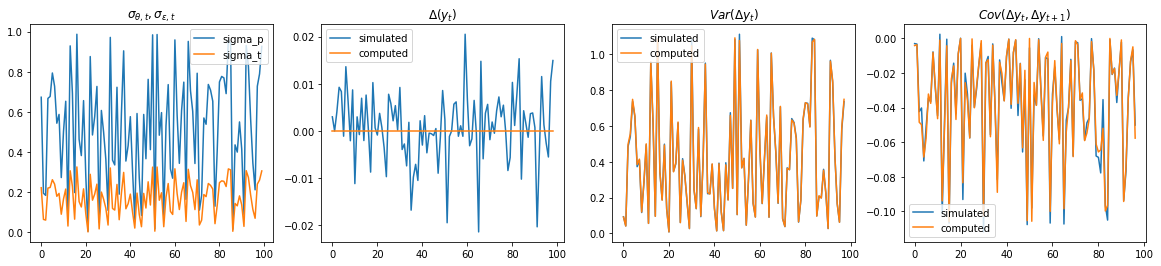

In [109]:
## plot simulated moments of first diff 

plt.figure(figsize=((20,4)))

plt.subplot(1,4,1)
plt.title(r'$\sigma_{\theta,t},\sigma_{\epsilon,t}$')
plt.plot(p_sigmas_draw,label='sigma_p')
plt.plot(t_sigmas,label='sigma_t')
plt.legend(loc=0)

plt.subplot(1,4,2)
plt.title(r'$\Delta(y_t)$')
plt.plot(av,label='simulated')
plt.plot(av_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,3)
plt.title(r'$Var(\Delta y_t)$')
plt.plot(var,label='simulated')
plt.plot(var_comp,label='computed')
plt.legend(loc=0)

plt.subplot(1,4,4)
plt.title(r'$Cov(\Delta y_t,\Delta y_{t+1})$')
plt.plot(autovarb1,label='simulated')
plt.plot(autovarb1_comp,label='computed')
plt.legend(loc = 0)

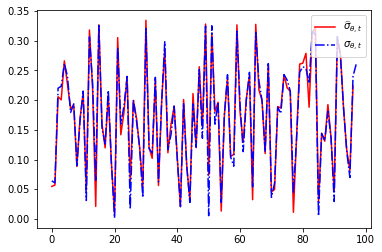

In [110]:
## robustness check if the transitory risks is approximately equal to the assigned level

sigma_t_est = np.array(np.sqrt(abs(autovarb1)))
plt.plot(sigma_t_est,'r-',label=r'$\widehat \sigma_{\theta,t}$')
plt.plot(t_sigmas[1:-1],'b-.',label=r'$\sigma_{\theta,t}$')  # the head and tail trimmed
plt.legend(loc=1)

### Time Aggregation

In [111]:
## time aggregation 

sim_data = dt.SimulateSeries(n_sim = 1000)
dt.n_agg = 3
agg_series = dt.TimeAggregate()
agg_series_moms = dt.SimulateMomentsAgg()

Text(0.5, 1.0, '1-degree autocovariance of different \n level of time aggregation')

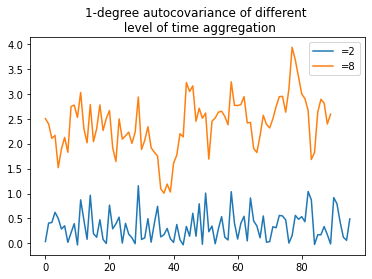

In [112]:
## difference times degree of time aggregation leads to different autocorrelation
for ns in np.array([2,8]):
    an_instance = cp.deepcopy(dt)
    an_instance.n_agg = ns
    series = an_instance.SimulateSeries(n_sim =500)
    agg_series = an_instance.TimeAggregate()
    agg_series_moms = an_instance.SimulateMomentsAgg()
    var_sim = an_instance.AutocovarAgg(step=0)
    var_b1 = an_instance.AutocovarAgg(step=-1)
    plt.plot(var_b1,label=r'={}'.format(ns))
plt.legend(loc=1)
plt.title('1-degree autocovariance of different \n level of time aggregation')

### Estimation

In [113]:
## some fake data moments with alternative parameters

## fix ratio of p and t risks
pt_ratio_fake = 0.66
t_sigmas = pt_ratio_fake * p_sigmas_draw # sizes of the time-varyingpermanent volatility

## both p and t risks are draws
p_sigmas_draw = np.random.uniform(0,1,t)
t_sigmas_draw = np.random.uniform(0,1,t)

sigmas = np.array([p_sigmas_draw,
                   t_sigmas_draw])

dt_fake = ima(t = t,
              ma_coeffs = ma_nosa)
dt_fake.sigmas = sigmas
data_fake = dt_fake.SimulateSeries(n_sim = 5000)
moms_fake = dt_fake.SimulatedMoments()

### Estimation using fake data

In [114]:
## estimation of income risks 

dt_est = cp.deepcopy(dt)
dt_est.GetDataMoments(moms_fake)

para_guess_this = np.ones(2*t  + dt_est.ma_q)  # make sure the length of the parameters are right 

In [115]:
para_est = dt_est.EstimatePara(method='BFGS',
                               para_guess = para_guess_this)

Optimization terminated successfully.
         Current function value: 1.181646
         Iterations: 133
         Function evaluations: 28886
         Gradient evaluations: 143


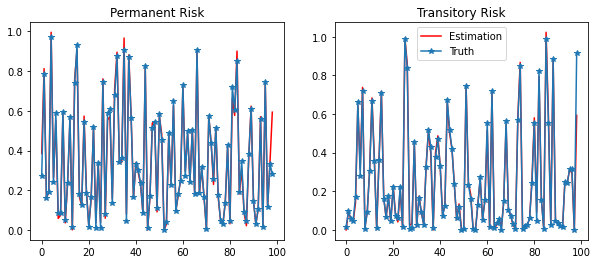

In [116]:
## check the estimation and true parameters 

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est[1][0][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est[1][1][1:].T**2,'r-',label='Estimation')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

### Estimation using PSID data



In [118]:
PSID = pd.read_stata('../../../PSID/J276289/psid_matrix.dta')   
PSID.index = PSID['uniqueid']
PSID = PSID.drop(['uniqueid'], axis=1)
PSID = PSID.dropna(axis=0,how='all')

In [119]:
data = np.array(PSID)

In [120]:
data.shape

(10781, 27)

In [149]:
data_mean = np.nanmean(data,axis=0)
data_var = ma.cov(ma.masked_invalid(data), rowvar=False)
moms_data = {'Mean':data_mean,
            'Var':data_var}

/Users/Myworld/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [150]:
## check the shape of the cov matrix 
data_var.shape

(27, 27)

In [151]:
## initialize 
dt_data_est = cp.deepcopy(dt)
t_data = len(data_var)+1
dt_data_est.t = t_data
dt_data_est.GetDataMoments(moms_data)
para_guess_this = np.ones(2*t_data + dt_data_est.ma_q)

In [152]:
## estimation
data_para_est = dt_data_est.EstimatePara(method='BFGS',
                               para_guess = para_guess_this)

Optimization terminated successfully.
         Current function value: 0.387958
         Iterations: 55
         Function evaluations: 3654
         Gradient evaluations: 63


In [153]:
## time stamp 
t0 = 1971
years = t0+np.arange(t_data-1)

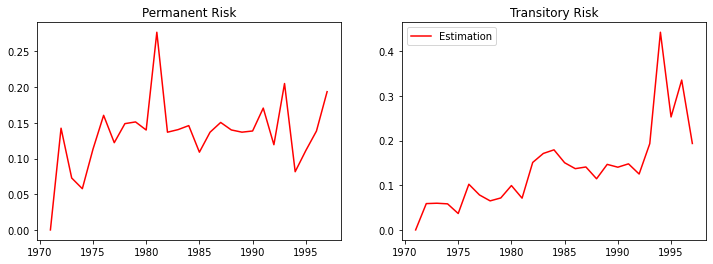

In [154]:
## check the estimation and true parameters 

fig = plt.figure(figsize=([12,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(years,
         dt_data_est.para_est[1][0][1:].T**2,
         'r-',label='Estimation')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(years,
         dt_data_est.para_est[1][1][1:].T**2,
         'r-',label='Estimation')
plt.legend(loc=0)

### Estimation using simulated moments 

In [16]:
"""
para_guess_this2 = para_guess_this*0.3

bounds_this = ((0,1),) + ((0,0.5),)*(2*t)

para_est_sim = dt_est.EstimateParabySim(method='TNC',
                                        para_guess = para_guess_this2,
                                        options={'disp':True}
                                       )
                                       
"""

In [155]:
"""
## check the estimation and true parameters

fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_sim[1][0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_sim[1][1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\n## check the estimation and true parameters\n\nfig = plt.figure(figsize=([10,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(dt_est.para_est_sim[1][0][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')\n\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(dt_est.para_est_sim[1][1][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

In [34]:
### reapeating the estimation for many times

"""
n_loop = 5

para_est_sum_sim = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParabySim(method='CG',
                                                  para_guess = para_guess_this2,
                                                  options = {'disp': True})
    para_est_sum_sim  = para_est_sum_sim + para_est_this_time
    
    
"""

"\nn_loop = 5\n\npara_est_sum_sim = (np.array([0]),np.zeros([2,50]))\nfor i in range(n_loop):\n    para_est_this_time = dt_est.EstimateParabySim(method='CG',\n                                                  para_guess = para_guess_this2,\n                                                  options = {'disp': True})\n    para_est_sum_sim  = para_est_sum_sim + para_est_this_time\n    \n    \n"

In [31]:
#para_est_av = sum([abs(para_est_sum_sim[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

In [35]:
## check the estimation and true parameters

"""
fig = plt.figure(figsize=([14,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av[0][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')


plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av[1][1:].T**2,'r-',label='Estimation(sim)')
plt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([14,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(para_est_av[0][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[0][1:]**2,'-*',label='Truth')\n\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(para_est_av[1][1:].T**2,'r-',label='Estimation(sim)')\nplt.plot(dt_fake.sigmas[1][1:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

#### Estimation using time aggregated data

In [36]:
## get some fake aggregated data moments
"""
moms_agg_fake = dt_fake.TimeAggregate()
moms_agg_dct_fake = dt_fake.SimulateMomentsAgg()
"""

'\nmoms_agg_fake = dt_fake.TimeAggregate()\nmoms_agg_dct_fake = dt_fake.SimulateMomentsAgg()\n'

In [37]:
## estimation 
"""
para_guess_this3 = para_guess_this*0.5
dt_est.GetDataMomentsAgg(moms_agg_dct_fake)
dt_est.n_periods = 12
para_est_agg = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001}
                                     )
                                     
"""

"\npara_guess_this3 = para_guess_this*0.5\ndt_est.GetDataMomentsAgg(moms_agg_dct_fake)\ndt_est.n_periods = 12\npara_est_agg = dt_est.EstimateParaAgg(method ='Powell',\n                                      para_guess = para_guess_this3,\n                                      options={'disp':True,\n                                              'ftol': 0.000000001}\n                                     )\n                                     \n"

In [38]:
## check the estimation and true parameters

"""
fig = plt.figure(figsize=([10,4]))

plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(dt_est.para_est_agg[1][0][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:-1]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(dt_est.para_est_agg[1][1][11:-1].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:-1]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([10,4]))\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(dt_est.para_est_agg[1][0][11:-1].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[0][11:-1]**2,'-*',label='Truth')\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(dt_est.para_est_agg[1][1][11:-1].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[1][11:-1]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"

In [39]:
### reapeating the estimation for many times

"""
n_loop = 5

para_est_sum_agg = (np.array([0]),np.zeros([2,50]))
for i in range(n_loop):
    para_est_this_time = dt_est.EstimateParaAgg(method ='Powell',
                                      para_guess = para_guess_this3,
                                      options={'disp':True,
                                              'ftol': 0.000000001})
    para_est_sum_agg = para_est_sum_agg + para_est_this_time
    
"""

"\nn_loop = 5\n\npara_est_sum_agg = (np.array([0]),np.zeros([2,50]))\nfor i in range(n_loop):\n    para_est_this_time = dt_est.EstimateParaAgg(method ='Powell',\n                                      para_guess = para_guess_this3,\n                                      options={'disp':True,\n                                              'ftol': 0.000000001})\n    para_est_sum_agg = para_est_sum_agg + para_est_this_time\n    \n"

In [40]:
para_est_av_agg = sum([abs(para_est_sum_agg[2*i+1]) for i in range(1,n_loop+1)] )/n_loop

NameError: name 'n_loop' is not defined

In [41]:
## check the estimation and true parameters


"""
fig = plt.figure(figsize=([14,4]))


plt.subplot(1,2,1)
plt.title('Permanent Risk')
plt.plot(para_est_av_agg[0][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[0][11:]**2,'-*',label='Truth')

plt.subplot(1,2,2)
plt.title('Transitory Risk')
plt.plot(para_est_av_agg[1][11:].T**2,'r-',label='Estimation(agg)')
plt.plot(dt_fake.sigmas[1][11:]**2,'-*',label='Truth')
plt.legend(loc=0)

"""

"\nfig = plt.figure(figsize=([14,4]))\n\n\nplt.subplot(1,2,1)\nplt.title('Permanent Risk')\nplt.plot(para_est_av_agg[0][11:].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[0][11:]**2,'-*',label='Truth')\n\nplt.subplot(1,2,2)\nplt.title('Transitory Risk')\nplt.plot(para_est_av_agg[1][11:].T**2,'r-',label='Estimation(agg)')\nplt.plot(dt_fake.sigmas[1][11:]**2,'-*',label='Truth')\nplt.legend(loc=0)\n\n"